In [2]:
import os
import numpy as np
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms
from torchvision.utils import save_image

import warnings
warnings.filterwarnings('ignore')

In [3]:
image_path = './images'
channels = 1                    # MNIST has only 1

n_epochs = 30
batch_size = 128
lr = 1e-3
b1 = 0.5 
b2 = 0.999

img_size = 28
hidden_dim = 400
latent_dim = 10

In [4]:
os.makedirs(image_path, exist_ok=True) 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

train = datasets.MNIST(root='./data/',train=True,transform=transform,download=True)
test = datasets.MNIST(root='./data/',train=False,transform=transform,download=True)

train_dataloader = torch.utils.data.DataLoader(
            train,
            batch_size=batch_size,
            shuffle=True,

)

test_dataloader = torch.utils.data.DataLoader(
            test,
            batch_size=batch_size,
            shuffle=False,
)

In [7]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

reparameterization의 input인 mu와 logvar는 각각 $\mu$와 $\log \sigma^2$을 뜻한다. 이때 mu와 logvar는 모두 10차원 tensor이고, eps는 각 element가 정규분포를 따르는 10차원 tensor이다. 이 함수는 최종적으로 $z=\mu + \sigma \odot \epsilon$을 반환한다.

In [8]:
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

Encoder는 784차원 tensor x를 input으로 받고 MLP를 거쳐 10차원의 latent z와 mu, logvar를 반환한다.

In [9]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

Decoder는 10차원의 latent z를 input으로 받고 MLP를 거쳐 784차원의 x_reconst를 반환한다.

In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)

In [11]:
print(encoder)

Encoder(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (mu): Linear(in_features=400, out_features=10, bias=True)
  (logvar): Linear(in_features=400, out_features=10, bias=True)
)


In [12]:
print(decoder)

Decoder(
  (fc1): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Linear(in_features=400, out_features=784, bias=True)
)


In [13]:
for epoch in range(n_epochs):
    train_loss = 0
    for i, (x, _) in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_dataloader)}], Reconst Loss : {reconst_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    print(f'===> Epoch: {epoch+1} Average Train Loss: {train_loss/len(train_dataloader.dataset):.4f} ')
    
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_dataloader):
            # forward
            x = x.view(-1, img_size**2)
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_reconst = decoder(z)

            # compute reconstruction loss and KL divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

            loss = reconst_loss + kl_div
            test_loss += loss.item()

            # save reconstruction images
            if i==0:
                x_concat = torch.cat([x.view(-1, 1, 28, 28), x_reconst.view(-1, 1, 28, 28)], dim=3)
                # batch size 개수만큼의 이미지 쌍(input x, reconstructed x)이 저장됨
                save_image(x_concat, os.path.join(image_path,f'reconst-epoch{epoch+1}.png'))

        print(f'===> Epoch: {epoch+1} Average Test Loss: {test_loss/len(test_dataloader.dataset):.4f} ')
        
        # save sampled images
        z = torch.randn(batch_size, latent_dim).to(device) # N(0, 1)에서 z 샘플링
        sampled_images = decoder(z)
        save_image(sampled_images.view(-1, 1, 28, 28), os.path.join(image_path,f'sampled-epoch{epoch+1}.png'))


Epoch [1/30], Step [10/469], Reconst Loss : 30216.4941, KL Div: 793.9560
Epoch [1/30], Step [20/469], Reconst Loss : 27337.0391, KL Div: 250.3848
Epoch [1/30], Step [30/469], Reconst Loss : 27287.3477, KL Div: 119.8987
Epoch [1/30], Step [40/469], Reconst Loss : 26411.3027, KL Div: 269.5617
Epoch [1/30], Step [50/469], Reconst Loss : 26041.1484, KL Div: 272.1458
Epoch [1/30], Step [60/469], Reconst Loss : 24844.4297, KL Div: 369.3223
Epoch [1/30], Step [70/469], Reconst Loss : 26283.3340, KL Div: 360.5064
Epoch [1/30], Step [80/469], Reconst Loss : 24683.5312, KL Div: 569.4824
Epoch [1/30], Step [90/469], Reconst Loss : 24536.9141, KL Div: 495.0694
Epoch [1/30], Step [100/469], Reconst Loss : 24707.9980, KL Div: 383.8151
Epoch [1/30], Step [110/469], Reconst Loss : 25000.3359, KL Div: 495.2276
Epoch [1/30], Step [120/469], Reconst Loss : 23968.7578, KL Div: 595.1979
Epoch [1/30], Step [130/469], Reconst Loss : 26386.5137, KL Div: 508.2888
Epoch [1/30], Step [140/469], Reconst Loss : 24

여기서 loss의 식은 다음과 같다.

$$ - \frac{1}{L} \sum_{l=1}^L \log p_{\boldsymbol \theta}(\mathbf x|\mathbf z^{(l)}) + \frac{1}{2} \sum_{j=1}^{10} \bigg( \mu_j^2+\sigma_j^2-\log \sigma_j^2-1 \bigg)$$

이 식에서 앞과 뒤의 항은 각각 reconst_loss, kl_div와 대응된다. reconst_loss의 경우 image domain에서는 주로 Bernoulli distribution을 사용하기 때문에 binary_cross_entropy를 사용했다고 한다.

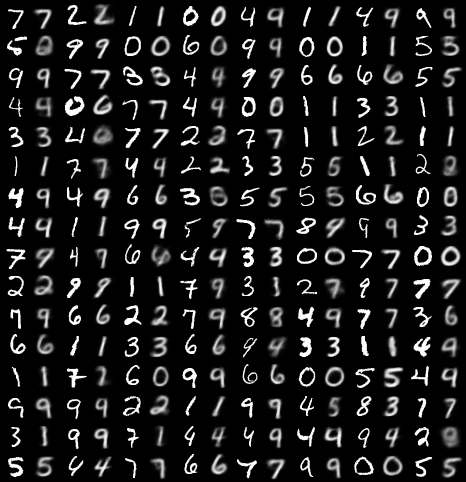

In [1]:
from PIL import Image

image_path = 'images/reconst-epoch30.png'

img = Image.open(image_path)

img.show()